In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os_path = './'

In [ ]:
import sys
sys.path.append('./DL_FinalProject/Sara_Changes')

In [ ]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff
from model_with_reconstruction import FixCapsNet

In [ ]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [ ]:
def get_data(trans_test=312):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os_path,""))  # get data root path
    image_path = os.path.join(data_root, "HAM100000")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [ ]:
BatchSize = 168
V_size = 40 
T_size = 32 
train_doc = "train525e384"
val_doc = "val525e384png"
test_doc = "test525png384"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 4 dataloader workers every process.
Using 7 classes.
using 51656 images for training, 1006 images for validation, 828 images for testing.


In [ ]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
# summary(network,(n_channels,img_size,img_size))

In [ ]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(18, 18), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [ ]:
dsize = (1, 3, 299, 299)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

+-------------+-----------+----------+-------+
|    Model    | Params(M) | FLOPs(G) |  FPS  |
+-------------+-----------+----------+-------+
| FixCaps-128 |   275.75  |   2.76   | 45.53 |
+-------------+-----------+----------+-------+


In [ ]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output, reconstruction, masked = network(data)  
        loss = network.loss(data, output, target, reconstruction, size_average=True)  
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [ ]:
def fgsm(model, X, y, epsilon=0.05):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    print(X.to(device).shape, delta.to(device).shape)
    output, reconstruction, masked = network(X.to(device)+delta.to(device)) 
    loss = network.loss(X.to(device)+delta.to(device), output, y.to(device), 
                        reconstruction, size_average=True)  
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd(model, X, y, epsilon=0.05, alpha=1e4, num_iter=50):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        output, reconstruction, masked = network(X.to(device)+delta.to(device)) 
        loss = network.loss(X.to(device)+delta.to(device), output, y.to(device), 
                        reconstruction, size_average=True) 
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
def test(split="test", attack_func=fgsm, has_attack=False, is_uap=False):
    delta = torch.unsqueeze(torch.from_numpy(np.load('./UAP_delta.npy')), 0)
  
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    reconstruction_norm_list = list()
  
    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        
        batch_idx +=1
        target_indices = target#torch.Size([batch, 7])  
        target_one_hot = one_hot(target, length=n_classes) 
        if not is_uap:
          if has_attack:
              delta = attack_func(network, data, target_one_hot)   
          else:
              delta = torch.zeros_like(data)  
        with torch.no_grad():    
            data, target = Variable(data+delta).to(device), Variable(target_one_hot).to(device)

            output, reconstruction, _  = network(data)#torch.Size([batch_size, 7, 16, 1])
            reconstruction_norm_list.extend(torch.norm(data-reconstruction, p=2, dim=(1,2,3)).flatten().tolist())
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]

        if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
            tmp_size = data_num % tmp_size
                      
        for i in range(tmp_size):
            pred_y = pred.numpy()
            evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result) 
    test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
    print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

    if split == 'val':
        val_acc_list.append(test_acc)
        if test_acc >= best_acc:
            best_acc = test_acc
            val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), save_PATH)
            torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
        print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
    else:
        test_acc_list.append(test_acc)
        if test_acc >= eval_acc:
            eval_acc = test_acc
            test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
            torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
        print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    return reconstruction_norm_list

In [ ]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0516_222552
./tmp/HAM10000/0516_222552/best_HAM10000_0516_222552.pth


In [ ]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

Loading the pretrained model

In [ ]:
network.load_state_dict(torch.load(
    os_path+'./best_HAM10000_0507_033609.pth'))

In [ ]:
num_epochs = 200

Finetuning model after adding the decoder module for 200 epochs.

In [ ]:
for epoch in range(1, num_epochs + 1): #4h 26m 46s
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.35513,ACC:0.32483
Train Epoch:[1] Loss:0.40205,Acc:0.37796,Best_train:0.37796
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:56.859%
Best_val:[56.859%]
[Train Epoch:[2]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.31364,ACC:0.46340
Train Epoch:[2] Loss:0.34188,Acc:0.47601,Best_train:0.47601
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:55.368%
Best_val:[56.859%]
[Train Epoch:[3]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.33019,ACC:0.51480
Train Epoch:[3] Loss:0.31667,Acc:0.51899,Best_train:0.51899
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:60.934%
Best_val:[60.934%]
[Train Epoch:[4]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28058,ACC:0.54190
Train Epoch:[4] Loss:0.29975,Acc:0.54731,Best_train:0.54731
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:62.823%
Best_val:[62.823%]
[Train Epoch:[5]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28025,ACC:0.56408
Train Epoch:[5] Loss:0.28974,Acc:0.56431,Best_train:0.56431
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:67.694%
Best_val:[67.694%]
[Train Epoch:[6]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.31703,ACC:0.56544
Train Epoch:[6] Loss:0.28811,Acc:0.56605,Best_train:0.56605
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:66.998%
Best_val:[67.694%]
[Train Epoch:[7]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29309,ACC:0.56884
Train Epoch:[7] Loss:0.28653,Acc:0.56969,Best_train:0.56969
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:69.682%
Best_val:[69.682%]
[Train Epoch:[8]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29182,ACC:0.56660
Train Epoch:[8] Loss:0.28679,Acc:0.56927,Best_train:0.56969
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:71.869%
Best_val:[71.869%]
[Train Epoch:[9]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.29823,ACC:0.57239
Train Epoch:[9] Loss:0.28587,Acc:0.57265,Best_train:0.57265
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:71.471%
Best_val:[71.869%]
[Train Epoch:[10]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.31120,ACC:0.57827
Train Epoch:[10] Loss:0.28082,Acc:0.58266,Best_train:0.58266
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:71.272%
Best_val:[71.869%]
[Train Epoch:[11]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28351,ACC:0.59323
Train Epoch:[11] Loss:0.27688,Acc:0.59118,Best_train:0.59118
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:63.221%
Best_val:[71.869%]
[Train Epoch:[12]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.28355,ACC:0.60641
Train Epoch:[12] Loss:0.26809,Acc:0.60702,Best_train:0.60702
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:69.781%
Best_val:[71.869%]
[Train Epoch:[13]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22238,ACC:0.62005
Train Epoch:[13] Loss:0.25944,Acc:0.62262,Best_train:0.62262
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.02%
Best_val:[80.02%]
[Train Epoch:[14]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27647,ACC:0.63126
Train Epoch:[14] Loss:0.25135,Acc:0.63373,Best_train:0.63373
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.02%
Best_val:[80.02%]
[Train Epoch:[15]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22303,ACC:0.64549
Train Epoch:[15] Loss:0.24470,Acc:0.64451,Best_train:0.64451
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.02%
Best_val:[80.02%]
[Train Epoch:[16]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24887,ACC:0.64800
Train Epoch:[16] Loss:0.24352,Acc:0.64837,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.529%
Best_val:[80.02%]
[Train Epoch:[17]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23782,ACC:0.64603
Train Epoch:[17] Loss:0.24305,Acc:0.64666,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.915%
Best_val:[80.915%]
[Train Epoch:[18]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23300,ACC:0.64150
Train Epoch:[18] Loss:0.24758,Acc:0.64289,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.938%
Best_val:[80.915%]
[Train Epoch:[19]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.27755,ACC:0.63111
Train Epoch:[19] Loss:0.25108,Acc:0.63511,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.429%
Best_val:[80.915%]
[Train Epoch:[20]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23713,ACC:0.63072
Train Epoch:[20] Loss:0.25292,Acc:0.63421,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.33%
Best_val:[80.915%]
[Train Epoch:[21]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25271,ACC:0.63489
Train Epoch:[21] Loss:0.25149,Acc:0.63764,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.523%
Best_val:[80.915%]
[Train Epoch:[22]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25805,ACC:0.64305
Train Epoch:[22] Loss:0.24598,Acc:0.64775,Best_train:0.64837
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.803%
Best_val:[82.803%]
[Train Epoch:[23]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24290,ACC:0.65805
Train Epoch:[23] Loss:0.23864,Acc:0.65774,Best_train:0.65774
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.441%
Best_val:[82.803%]
[Train Epoch:[24]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21382,ACC:0.66906
Train Epoch:[24] Loss:0.23160,Acc:0.66999,Best_train:0.66999
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:76.441%
Best_val:[82.803%]
[Train Epoch:[25]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23546,ACC:0.67467
Train Epoch:[25] Loss:0.22686,Acc:0.67694,Best_train:0.67694
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.219%
Best_val:[82.803%]
[Train Epoch:[26]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23809,ACC:0.67811
Train Epoch:[26] Loss:0.22673,Acc:0.67779,Best_train:0.67779
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.809%
Best_val:[82.803%]
[Train Epoch:[27]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23247,ACC:0.67954
Train Epoch:[27] Loss:0.22545,Acc:0.67872,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[82.803%]
[Train Epoch:[28]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22371,ACC:0.66856
Train Epoch:[28] Loss:0.23052,Acc:0.66980,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.125%
Best_val:[82.803%]
[Train Epoch:[29]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25185,ACC:0.66752
Train Epoch:[29] Loss:0.23434,Acc:0.66591,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.827%
Best_val:[82.803%]
[Train Epoch:[30]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.24424,ACC:0.66087
Train Epoch:[30] Loss:0.23809,Acc:0.65996,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.604%
Best_val:[82.803%]
[Train Epoch:[31]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.25059,ACC:0.66415
Train Epoch:[31] Loss:0.23634,Acc:0.66407,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:71.074%
Best_val:[82.803%]
[Train Epoch:[32]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22446,ACC:0.66701
Train Epoch:[32] Loss:0.23281,Acc:0.66803,Best_train:0.67872
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.61%
Best_val:[82.803%]
[Train Epoch:[33]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22337,ACC:0.68097
Train Epoch:[33] Loss:0.22558,Acc:0.68184,Best_train:0.68184
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.628%
Best_val:[82.803%]
[Train Epoch:[34]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21766,ACC:0.68437
Train Epoch:[34] Loss:0.22170,Acc:0.68908,Best_train:0.68908
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.026%
Best_val:[82.803%]
[Train Epoch:[35]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21617,ACC:0.70250
Train Epoch:[35] Loss:0.21394,Acc:0.70129,Best_train:0.70129
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[83.201%]
[Train Epoch:[36]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19980,ACC:0.70157
Train Epoch:[36] Loss:0.21377,Acc:0.70184,Best_train:0.70184
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.207%
Best_val:[83.201%]
[Train Epoch:[37]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22568,ACC:0.70250
Train Epoch:[37] Loss:0.21444,Acc:0.70286,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[83.201%]
[Train Epoch:[38]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20329,ACC:0.69620
Train Epoch:[38] Loss:0.21751,Acc:0.69560,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:74.453%
Best_val:[83.201%]
[Train Epoch:[39]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22430,ACC:0.68437
Train Epoch:[39] Loss:0.22284,Acc:0.68708,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.394%
Best_val:[84.394%]
[Train Epoch:[40]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23280,ACC:0.68162
Train Epoch:[40] Loss:0.22540,Acc:0.68368,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[86.68%]
[Train Epoch:[41]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22805,ACC:0.68758
Train Epoch:[41] Loss:0.22427,Acc:0.68464,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:47.117%
Best_val:[86.68%]
[Train Epoch:[42]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.23360,ACC:0.68619
Train Epoch:[42] Loss:0.22277,Acc:0.68826,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.92%
Best_val:[86.68%]
[Train Epoch:[43]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21087,ACC:0.70145
Train Epoch:[43] Loss:0.21615,Acc:0.69916,Best_train:0.70286
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:69.881%
Best_val:[86.68%]
[Train Epoch:[44]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20612,ACC:0.70972
Train Epoch:[44] Loss:0.20961,Acc:0.70859,Best_train:0.70859
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:77.634%
Best_val:[86.68%]
[Train Epoch:[45]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21429,ACC:0.71452
Train Epoch:[45] Loss:0.20481,Acc:0.71850,Best_train:0.71850
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.61%
Best_val:[86.68%]
[Train Epoch:[46]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20236,ACC:0.71846
Train Epoch:[46] Loss:0.20345,Acc:0.71877,Best_train:0.71877
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:81.213%
Best_val:[86.68%]
[Train Epoch:[47]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21470,ACC:0.72294
Train Epoch:[47] Loss:0.20422,Acc:0.71965,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.306%
Best_val:[86.68%]
[Train Epoch:[48]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.22414,ACC:0.71463
Train Epoch:[48] Loss:0.20827,Acc:0.71239,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.529%
Best_val:[86.68%]
[Train Epoch:[49]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21780,ACC:0.70528
Train Epoch:[49] Loss:0.21358,Acc:0.70371,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:80.915%
Best_val:[86.68%]
[Train Epoch:[50]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21281,ACC:0.69971
Train Epoch:[50] Loss:0.21741,Acc:0.69686,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:82.903%
Best_val:[86.68%]
[Train Epoch:[51]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20097,ACC:0.70327
Train Epoch:[51] Loss:0.21628,Acc:0.69969,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.581%
Best_val:[86.68%]
[Train Epoch:[52]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18299,ACC:0.70613
Train Epoch:[52] Loss:0.21407,Acc:0.70207,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:79.026%
Best_val:[86.68%]
[Train Epoch:[53]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21901,ACC:0.71359
Train Epoch:[53] Loss:0.20808,Acc:0.71196,Best_train:0.71965
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.101%
Best_val:[86.68%]
[Train Epoch:[54]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.17426,ACC:0.71997
Train Epoch:[54] Loss:0.20201,Acc:0.72148,Best_train:0.72148
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:84.195%
Best_val:[86.68%]
[Train Epoch:[55]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20326,ACC:0.72975
Train Epoch:[55] Loss:0.19749,Acc:0.72865,Best_train:0.72865
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.68%
Best_val:[86.68%]
[Train Epoch:[56]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.16621,ACC:0.73578
Train Epoch:[56] Loss:0.19564,Acc:0.73420,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.084%
Best_val:[86.68%]
[Train Epoch:[57]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.19609,ACC:0.72789
Train Epoch:[57] Loss:0.19684,Acc:0.73095,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.487%
Best_val:[86.68%]
[Train Epoch:[58]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20135,ACC:0.72097
Train Epoch:[58] Loss:0.20124,Acc:0.72257,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.897%
Best_val:[86.68%]
[Train Epoch:[59]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18521,ACC:0.71722
Train Epoch:[59] Loss:0.20550,Acc:0.71730,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.487%
Best_val:[86.68%]
[Train Epoch:[60]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.18928,ACC:0.71456
Train Epoch:[60] Loss:0.20972,Acc:0.71144,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.201%
Best_val:[86.68%]
[Train Epoch:[61]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21947,ACC:0.70992
Train Epoch:[61] Loss:0.21006,Acc:0.71012,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:86.779%
Best_val:[86.779%]
[Train Epoch:[62]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21403,ACC:0.71989
Train Epoch:[62] Loss:0.20631,Acc:0.71831,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:78.728%
Best_val:[86.779%]
[Train Epoch:[63]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.21396,ACC:0.72476
Train Epoch:[63] Loss:0.20121,Acc:0.72410,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:83.797%
Best_val:[86.779%]
[Train Epoch:[64]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

[154/308] Loss0.20733,ACC:0.72851
Train Epoch:[64] Loss:0.19675,Acc:0.73159,Best_train:0.73420
HAM10000 ==> val ...


  0%|          | 0/26 [00:00<?, ?it/s]

val_Acc:85.586%
Best_val:[86.779%]
[Train Epoch:[65]HAM10000 ==> Training] ...


  0%|          | 0/308 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[HAM10000]
Best_Epoch [61]
[Val] ACC:86.78%.


Loading the fine-tuned model.

In [ ]:
network.load_state_dict(torch.load(
    os_path+'/Sara_Changes/best_HAM10000_0513_163808.pth'))

<All keys matched successfully>

Showing some samples

  0%|          | 0/26 [00:00<?, ?it/s]

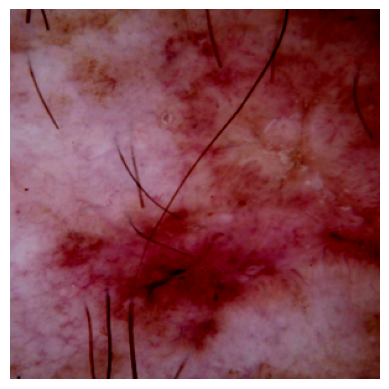

torch.Size([1, 3, 299, 299]) torch.Size([1, 3, 299, 299])


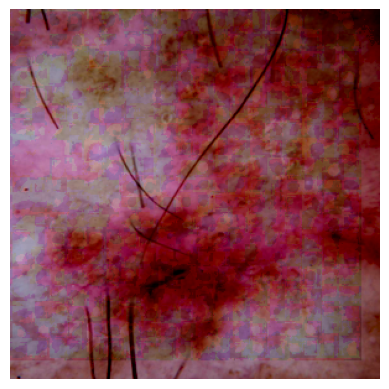

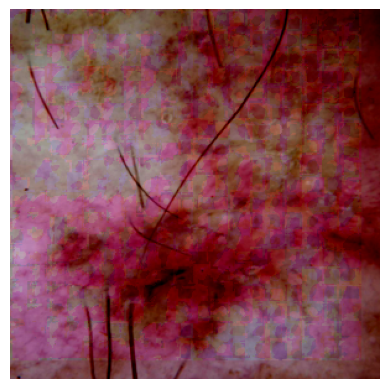

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
idx_list = [2, 10]
for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
  for idx in idx_list:

    imgplot = plt.imshow(data[idx].transpose(0,2))
    #plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    plt.axis('off')
    plt.show()
    target_one_hot = one_hot(target[idx].unsqueeze(0), length=n_classes) 
    delta = fgsm(X=data[idx].unsqueeze(0), y=target_one_hot, model=network)
    imgplot = plt.imshow((data[idx]+delta).squeeze(0).transpose(0,2))
    #plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    plt.axis('off')
    plt.show()
    delta = pgd(X=data[idx].unsqueeze(0), y=target_one_hot, model=network)
    imgplot = plt.imshow((data[idx]+delta).squeeze(0).transpose(0,2))
    #plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
    plt.axis('off')
    plt.show()
  break

In [ ]:
reconstruction_list = test()

HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:89.976%
Best_eval:[89.976%]


In [ ]:
attack_reconstruction_list = test(has_attack=True)

HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:1.691%
Best_eval:[89.976%]


In [ ]:
pgd_attack_reconstruction_list = test(attack_func=pgd, has_attack=True)

HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:1.087%
Best_eval:[89.976%]


In [ ]:
uap_attack_reconstruction_list = test(is_uap=True)

HAM10000 ==> test ...


  0%|          | 0/26 [00:00<?, ?it/s]

test_Acc:33.575%
Best_eval:[89.976%]


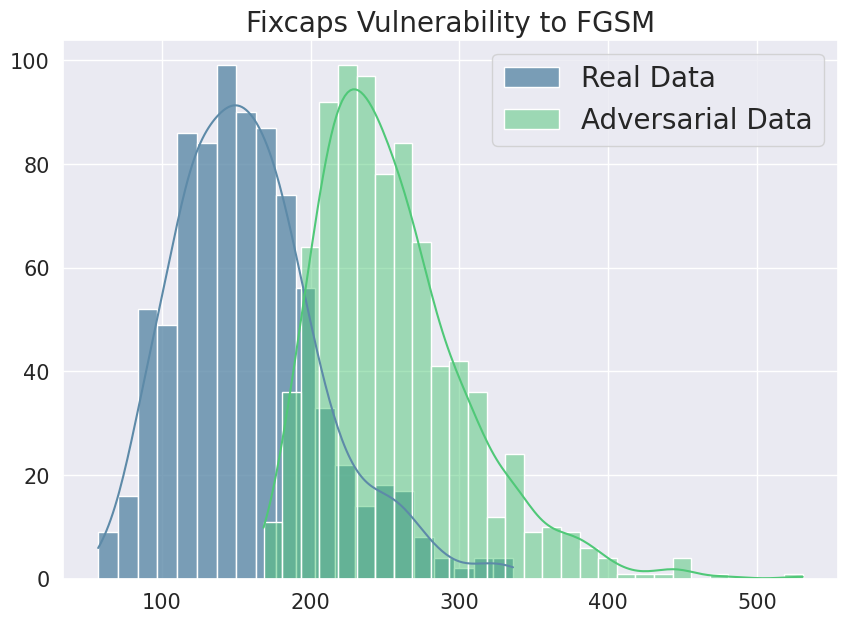

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Creating histogram
plt.rcParams['font.size'] = 2

fig, ax = plt.subplots(figsize =(10, 7))
sns.histplot(data=reconstruction_list, color="#5D8AA8", label="Real Data", 
             alpha = 0.8, kde=True)
sns.histplot(data=attack_reconstruction_list, color="#50C878",
             label="Adversarial Data",alpha = 0.5, kde=True)
plt.title("Fixcaps Vulnerability to FGSM", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.legend(fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()



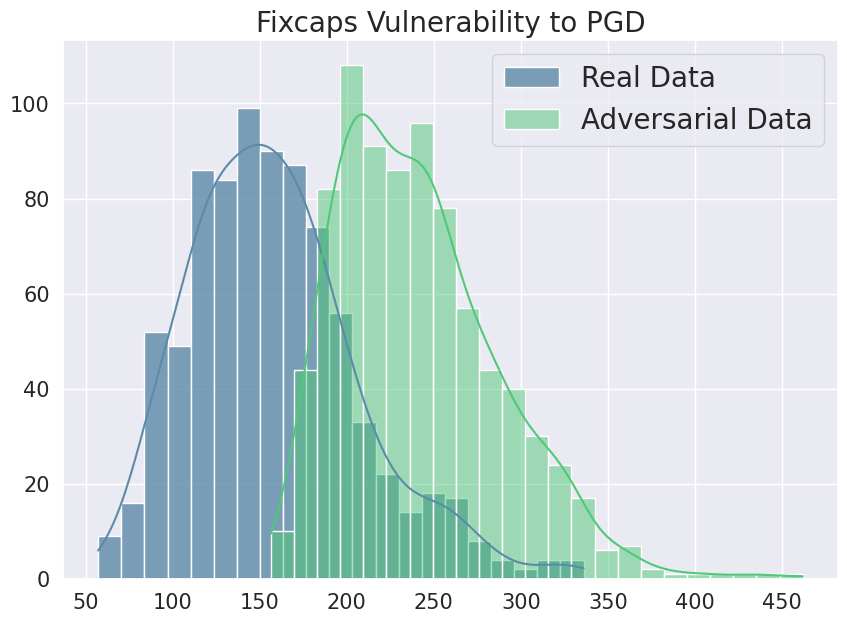

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# Creating histogram

fig, ax = plt.subplots(figsize =(10, 7))
sns.histplot(data=reconstruction_list, color="#5D8AA8", label="Real Data", alpha = 0.8, kde=True)
sns.histplot(data=pgd_attack_reconstruction_list, color="#50C878", label="Adversarial Data",alpha = 0.5, kde=True)
plt.title("Fixcaps Vulnerability to PGD", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.legend(fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

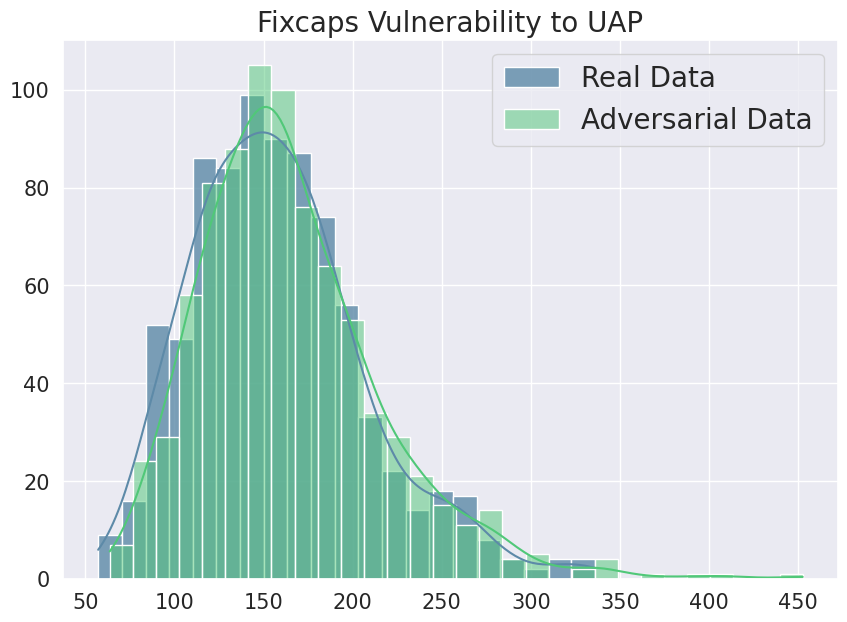

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# Creating histogram

fig, ax = plt.subplots(figsize =(10, 7))
sns.histplot(data=reconstruction_list, color="#5D8AA8", label="Real Data", alpha = 0.8, kde=True)
sns.histplot(data=uap_attack_reconstruction_list, color="#50C878", label="Adversarial Data",alpha = 0.5, kde=True)
plt.title("Fixcaps Vulnerability to UAP", fontsize=20)
plt.xlabel("")
plt.ylabel("")
plt.legend(fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()